In [1]:
# ! pip install statsmodels
# ! pip install seaborn
# ! pip install scikit_posthocs

In [2]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
from scipy.stats import f_oneway

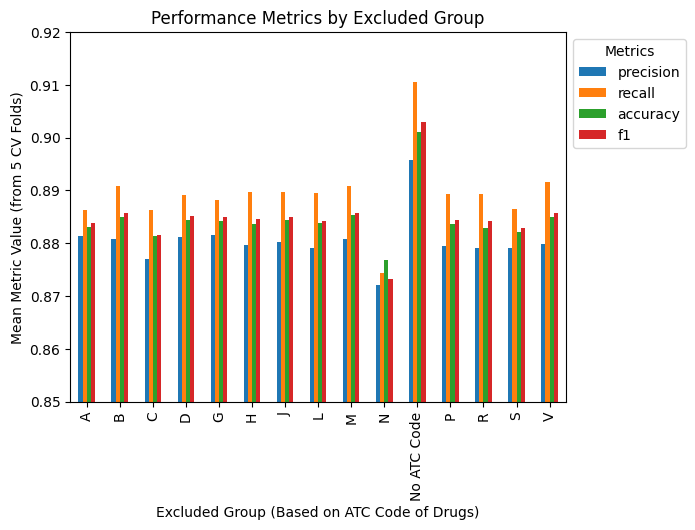

In [7]:
data = pd.read_csv("./drug/2024-07-03/openpredict_drug_targets_scores_2024-07-03.csv")

numeric_data_atc = data.drop(columns=['method', 'excluded group', 'fold'])

numeric_data_agg = numeric_data_atc.groupby('excluded group atc').mean()

ax = numeric_data_agg[['precision', 'recall', 'accuracy', 'f1']].plot(kind='bar')
ax.set_ylim(0.85, 0.92)
ax.legend(title="Metrics", loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Performance Metrics by Excluded Group')
plt.ylabel('Mean Metric Value (from 5 CV Folds)')
plt.xlabel('Excluded Group (Based on ATC Code of Drugs)')
plt.savefig('performance_metrics_by_excluded_group.png',bbox_inches='tight')
plt.show()

In [6]:
numeric_data_agg_fixed = numeric_data_agg.reset_index()
numeric_data_agg_fixed = numeric_data_agg_fixed.rename(columns={'excluded group atc': 'excluded_group_atc'})
display(numeric_data_agg_fixed)

,excluded_group_atc,precision,recall,accuracy,f1,average_precision
0,A,0.881391,0.886327,0.883033,0.883784,0.950383
1,B,0.880747,0.890820,0.884868,0.885731,0.950612
2,C,0.876998,0.886333,0.881291,0.881609,0.950064
3,D,0.881253,0.889042,0.884378,0.885117,0.950905
4,G,0.881602,0.888242,0.884174,0.884895,0.950301
5,H,0.879590,0.889718,0.883594,0.884599,0.951824
6,J,0.880191,0.889726,0.884317,0.884932,0.951657
7,L,0.879076,0.889488,0.883916,0.884243,0.950064
8,M,0.880768,0.890888,0.885246,0.885745,0.951241
9,N,0.872173,0.874325,0.876815,0.873196,0.944536


In [11]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal, mannwhitneyu
from itertools import combinations

# make a list containing 'precision', 'recall', 'accuracy', 'f1' strings
metrics = ['precision', 'recall', 'accuracy', 'f1']
# make a list of dataframes that is empty
results_df_list = []

for metric in metrics:
    grouped_data = {group: values[metric].values for group, values in numeric_data_atc.groupby('excluded group atc')}

    # Kruskal-Wallis H Test
    stat, p_value_kw = kruskal(*grouped_data.values())
    print(f'Metric: {metric}, Kruskal-Wallis Statistic: {stat}, P-value: {p_value_kw} \n')

    # Conduct Mann-Whitney U tests if Kruskal-Wallis test is significant
    if p_value_kw < 0.05:
        group_keys = list(grouped_data.keys())
        combinations_of_groups = list(combinations(group_keys, 2))
        num_comparisons = len(combinations_of_groups)
        alpha = 0.05 / num_comparisons  # Bonferroni correction

        results = []
        for (group1, group2) in combinations_of_groups:
            stat, p_value_mw = mannwhitneyu(grouped_data[group1], grouped_data[group2], alternative='two-sided')
            results.append((group1, group2, p_value_mw, p_value_mw < alpha))
        
        results_df = pd.DataFrame(results, columns=['Group 1', 'Group 2', 'P-value', 'Significant'])
        # add results_df to results_df_list
        results_df_list.append(results_df)
        print(results_df)
    else:
        print("No significant differences found by Kruskal-Wallis, no further tests conducted.")

Metric: precision, Kruskal-Wallis Statistic: 13.216165467011852, P-value: 0.5095776352418488 

No significant differences found by Kruskal-Wallis, no further tests conducted.
Metric: recall, Kruskal-Wallis Statistic: 26.221377564084335, P-value: 0.02425876687777578 

    Group 1 Group 2   P-value  Significant
0         A       B  0.841270        False
1         A       C  0.675174        False
2         A       D  1.000000        False
3         A       G  1.000000        False
4         A       H  1.000000        False
..      ...     ...       ...          ...
100       P       S  0.690476        False
101       P       V  0.690476        False
102       R       S  0.547619        False
103       R       V  0.547619        False
104       S       V  0.222222        False

[105 rows x 4 columns]
Metric: accuracy, Kruskal-Wallis Statistic: 19.63480561601159, P-value: 0.1420819810659814 

No significant differences found by Kruskal-Wallis, no further tests conducted.
Metric: f1, Kruskal

In [30]:
for df in results_df_list:
    print(df[df['Significant'] == True])

Empty DataFrame
Columns: [Group 1, Group 2, P-value, Significant]
Index: []
Empty DataFrame
Columns: [Group 1, Group 2, P-value, Significant]
Index: []


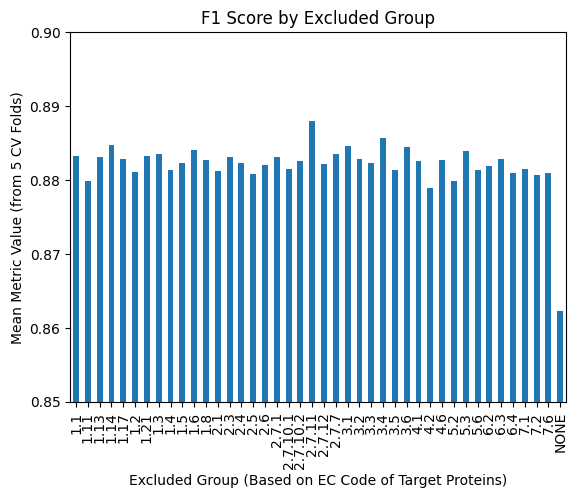

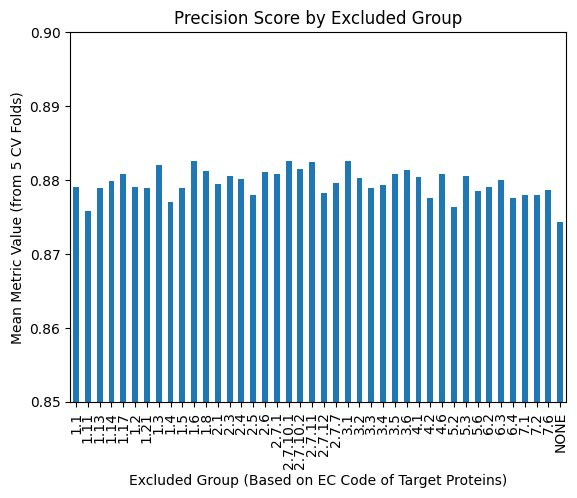

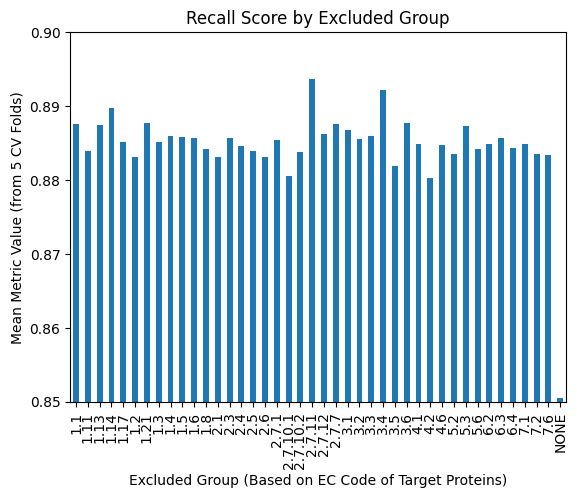

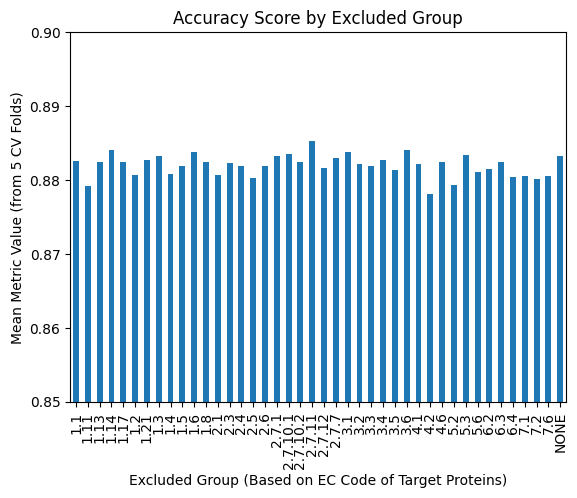

In [12]:
# data = pd.read_csv("../tests/openpredict_drug_targets_scores_2024-07-08.csv")
data = pd.read_csv("openpredict_drug_targets_scores_2024-08-02.csv")

numeric_data_ec = data.drop(columns=['method', 'excluded group', 'fold'])

numeric_data_agg = numeric_data_ec.groupby('excluded group ec').mean()
ax = numeric_data_agg[['f1']].plot(kind='bar')

# ax = numeric_data_agg[['precision', 'recall', 'accuracy', 'f1']].plot(kind='bar')
ax.set_ylim(0.85, 0.9)
ax.get_legend().remove()
#ax.legend(title="Metrics", loc='upper left', bbox_to_anchor=(1, 1))
plt.title('F1 Score by Excluded Group')
plt.ylabel('Mean Metric Value (from 5 CV Folds)')
plt.xlabel('Excluded Group (Based on EC Code of Target Proteins)')
plt.savefig('performance_metrics_by_excluded_ec_group_f1.png',bbox_inches='tight')
plt.show()

ax = numeric_data_agg[['precision']].plot(kind='bar')

# ax = numeric_data_agg[['precision', 'recall', 'accuracy', 'f1']].plot(kind='bar')
ax.set_ylim(0.85, 0.9)
ax.get_legend().remove()
#ax.legend(title="Metrics", loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Precision Score by Excluded Group')
plt.ylabel('Mean Metric Value (from 5 CV Folds)')
plt.xlabel('Excluded Group (Based on EC Code of Target Proteins)')
plt.savefig('performance_metrics_by_excluded_ec_group_precision.png',bbox_inches='tight')
plt.show()

ax = numeric_data_agg[['recall']].plot(kind='bar')

# ax = numeric_data_agg[['precision', 'recall', 'accuracy', 'f1']].plot(kind='bar')
ax.set_ylim(0.85, 0.9)
ax.get_legend().remove()
#ax.legend(title="Metrics", loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Recall Score by Excluded Group')
plt.ylabel('Mean Metric Value (from 5 CV Folds)')
plt.xlabel('Excluded Group (Based on EC Code of Target Proteins)')
plt.savefig('performance_metrics_by_excluded_ec_group_recall.png',bbox_inches='tight')
plt.show()

ax = numeric_data_agg[['accuracy']].plot(kind='bar')

# ax = numeric_data_agg[['precision', 'recall', 'accuracy', 'f1']].plot(kind='bar')
ax.set_ylim(0.85, 0.9)
ax.get_legend().remove()
#ax.legend(title="Metrics", loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Accuracy Score by Excluded Group')
plt.ylabel('Mean Metric Value (from 5 CV Folds)')
plt.xlabel('Excluded Group (Based on EC Code of Target Proteins)')
plt.savefig('performance_metrics_by_excluded_ec_group_accuracy.png',bbox_inches='tight')
plt.show()

In [32]:
# from scipy.stats import kruskal

# # Grouping F1 scores by 'excluded group ec' and converting to a dictionary
# grouped_f1 = numeric_data_ec.groupby('excluded group ec')['f1'].apply(list).to_dict()

# # Create a DataFrame from the dictionary
# df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in grouped_f1.items()]))

# # Melting the DataFrame
# df_melt = df.melt(var_name='group', value_name='f1_score')

# # Extract groups for the test
# data_groups = [group['f1_score'].dropna().values for name, group in df_melt.groupby('group')]

# # Kruskal-Wallis H Test
# stat, p_value = kruskal(*data_groups)

# print(f'Statistic: {stat}, P-value: {p_value}')

In [35]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal, mannwhitneyu
from itertools import combinations

# make a list containing 'precision', 'recall', 'accuracy', 'f1' strings
metrics = ['precision', 'recall', 'accuracy', 'f1']

for metric in metrics:
    grouped_data = {group: values[metric].values for group, values in numeric_data_ec.groupby('excluded group ec')}

    # Kruskal-Wallis H Test
    stat, p_value_kw = kruskal(*grouped_data.values())
    print(f'Metric: {metric}, Kruskal-Wallis Statistic: {stat}, P-value: {p_value_kw}')

    # Conduct Mann-Whitney U tests if Kruskal-Wallis test is significant
    if p_value_kw < 0.05:
        group_keys = list(grouped_data.keys())
        combinations_of_groups = list(combinations(group_keys, 2))
        num_comparisons = len(combinations_of_groups)
        alpha = 0.05 / num_comparisons  # Bonferroni correction

        results = []
        for (group1, group2) in combinations_of_groups:
            stat, p_value_mw = mannwhitneyu(grouped_data[group1], grouped_data[group2], alternative='two-sided')
            results.append((group1, group2, p_value_mw, p_value_mw < alpha))
        
        results_df = pd.DataFrame(results, columns=['Group 1', 'Group 2', 'P-value', 'Significant'])
        print(results_df)
    else:
        print("No significant differences found by Kruskal-Wallis, no further tests conducted.")

Metric: precision, Kruskal-Wallis Statistic: 14.501757284440622, P-value: 0.9999584590237155
No significant differences found by Kruskal-Wallis, no further tests conducted.
Metric: recall, Kruskal-Wallis Statistic: 26.198522126634582, P-value: 0.9649217822844188
No significant differences found by Kruskal-Wallis, no further tests conducted.
Metric: accuracy, Kruskal-Wallis Statistic: 15.755423571890663, P-value: 0.9998733072408411
No significant differences found by Kruskal-Wallis, no further tests conducted.
Metric: f1, Kruskal-Wallis Statistic: 25.12958200190192, P-value: 0.9757532890763468
No significant differences found by Kruskal-Wallis, no further tests conducted.


In [37]:
# # RETIRED CODE

# import numpy as np
# import pandas as pd
# from scipy.stats import f_oneway
# from statsmodels.stats.multicomp import pairwise_tukeyhsd

# # Setting a random seed for reproducibility
# np.random.seed(42)

# # Generating random F1 scores for each of 10 groups
# # groups = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
# # data = {group: np.random.normal(loc=np.random.uniform(0.8, 0.9), scale=0.05, size=5) for group in groups}
# #print (data)
# #print(numeric_data[['excluded group ec', 'f1']])
# grouped_f1 = numeric_data.groupby('excluded group ec')['f1'].apply(np.array).to_dict()
# groups = list(grouped_f1.keys())
# #print(grouped_f1)

# df = pd.DataFrame(grouped_f1)
# df_melt = df.melt(var_name='group', value_name='f1_score')

# # Performing ANOVA
# anova_result = f_oneway(*(df[group].values for group in groups))

# # Output ANOVA results
# print(f"ANOVA result: F-statistic = {anova_result.statistic:.2f}, p-value = {anova_result.pvalue:.4f}")

# # Proceeding with Tukey's HSD test if ANOVA is significant

# if anova_result.pvalue < 0.05:
#     tukey = pairwise_tukeyhsd(endog=df_melt['f1_score'], groups=df_melt['group'], alpha=0.05)
#     print(tukey)
# else:
#     print("No significant differences found. No need for further testing.")

ANOVA Results
F-statistic = 1.62: This value indicates the ratio of the variance between the groups to the variance within the groups. A higher value typically suggests a significant difference between the group means.
P-value = 0.0184: The p-value is below the conventional threshold of 0.05, indicating that there are statistically significant differences among the mean F1 scores of the 10 groups. This suggests rejecting the null hypothesis that all group means are equal.

In [41]:
# tukey_summary = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# significant_results = tukey_summary[tukey_summary['reject'] == True]

# print(significant_results)

       group1 group2  meandiff   p-adj   lower   upper  reject
40        1.1   NONE   -0.0211  0.0002 -0.0367 -0.0054    True
80       1.11   NONE   -0.0176  0.0083 -0.0333 -0.0020    True
119      1.13   NONE   -0.0208  0.0003 -0.0365 -0.0052    True
157      1.14   NONE   -0.0226  0.0000 -0.0382 -0.0069    True
194      1.17   NONE   -0.0207  0.0003 -0.0363 -0.0050    True
230       1.2   NONE   -0.0188  0.0026 -0.0344 -0.0031    True
265      1.21   NONE   -0.0210  0.0002 -0.0367 -0.0054    True
299       1.3   NONE   -0.0213  0.0002 -0.0369 -0.0056    True
332       1.4   NONE   -0.0191  0.0018 -0.0348 -0.0035    True
364       1.5   NONE   -0.0201  0.0006 -0.0357 -0.0044    True
395       1.6   NONE   -0.0219  0.0001 -0.0375 -0.0062    True
425       1.8   NONE   -0.0205  0.0004 -0.0361 -0.0048    True
454       2.1   NONE   -0.0190  0.0021 -0.0346 -0.0033    True
482       2.3   NONE   -0.0209  0.0003 -0.0365 -0.0052    True
509       2.4   NONE   -0.0201  0.0006 -0.0358 -0.0045 

There are a couple of cases (e.g., '7.2 vs NONE' and '7.6 vs NONE') where the difference was significant, as indicated by a "True" in the 'reject' column and a p-value well below 0.05. This suggests that these groups (7.2 and 7.6 and others) differ significantly from the 'NONE' group in terms of mean F1 scores.